<a href="https://colab.research.google.com/github/numagic/lumos/blob/update_colab_example/Custom_Objective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this example, we'll show one can create custom objective functions using automatic differentiation.

Usually it is recommended to use lumos with the docker image it provides. But we can also run `lumos` with conda environment.

Google Colab provides free GPU and TPU VMs that one could use with jupyter notebook style UI, and this is what we're going to use.

To set up the environment, we'll:
1) install conda on google colab using `condacolab`
2) clone the `lumos` git repo, and setup the conda environment (this will be replaced by pip install in the future)
3) run the exmaples

# Install Conda on Google Colab

<!-- By Jaime Rodríguez-Guerra <@jaimergp>. Last modified 2021.08.04 -->

`condacolab` simplifies the setup as much as possible, but there are some gotchas.

**⚠️ Read this before continuing!**

* The `condacolab` commands need to be run the first Code cell!
* Once you run `condacolab.install()`, the Python kernel will be restarted. This is **normal and expected**. After that, you can continue running the cells below like normal.
* Do not use the `Run all` option. Run the `condacolab` cell _individually_ and wait for the kernel to restart. **Only then**, you can run all cells if you want.
* You can only use the `base` environment. Do not try to create new ones; instead update `base` with either:
  * `conda install <packages>`
  * `conda env update -n base -f environment.yml`
* If you want to use GPUs, make sure you are using such an instance before starting!
* If you get an error, please raise an issue [here](https://github.com/jaimergp/condacolab/issues).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:01:04
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [1]:
# We could set up the dependencies using enviornment.yml
# !git clone https://github.com/numagic/lumos
# %cd /content/lumos
# !git checkout dev
# !conda env update -n base -f environment.yml

# Or... we could direclty install them so we don't need to clone the repo
# TODO: make dependency automatic -> this would require conda as there are
# non-python dependencies
!conda install -c conda-forge cyipopt
!pip install jax[cpu] casadi pyarrow pandas matplotlib
!pip install numagic-lumos==0.0.2rc5

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cyipopt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ampl-mp-3.1.0              |    h2cc385e_1006         1.1 MB  conda-forge
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  conda-forge
    certifi-2022.6.15          |   py37h89c1867_0         155 KB  conda-forge
    conda-4.14.0               |   py37h89c1867_0        1010 KB  conda-forge
    cyipopt-1.1.0              |   py37hb2fd402_3         135 KB  conda-forge
    future-0.18.2              |   py37h89c1867_5         713 KB  conda-forge


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 4.2 MB/s 


# Automatic differentiation

It is important to point out that:
1) lumos does *NOT* have its own automatic differentiation framework, it merely leverages existing ones (from jax and casadi) for the model algebra
2) for the objective function, the user is free to use any method they want, as long as it gives lumos the required ingredients needed eventually (we'll go into more detials of that later). 

Here we show a simple example of how to use jax to do the automatic differentiation. If you want, you can also use casadi, autograd, numba, etc, or even just finite difference.

In [32]:
import jax.numpy as jnp
from jax import grad, hessian

# Create a custom objective function with a small weight that it will change
# the result, but still makes for a good solve.
def new_obj_fn(x):
    return jnp.sum(x**2)*1e-3

# Use AD to get the gradient
new_grad = grad(new_obj_fn)

# Use AD to get the hessian
new_hess = hessian(new_obj_fn)

# lumos would want a 1d array of the non-sparse elements of the hessian, so we
# defnite another function for that.
flat_hess = lambda x: new_hess(x).flatten()

# Now let's call the function we created.
x = np.random.randn(5)

print(f"input: {x}")
print(f"objective is: {new_obj_fn(x)}")
print(f"gradient is: {new_grad(x)}")
print(f"hessian is: {new_hess(x)}")

print(f"flat hessian is: {flat_hess(x)}")

input: [ 0.53061953 -0.01808378  0.42686665  0.19080753 -0.62888173]
objective is: 0.0008959989828500646
gradient is: [ 1.06123905e-03 -3.61675543e-05  8.53733300e-04  3.81615050e-04
 -1.25776346e-03]
hessian is: [[0.002 0.    0.    0.    0.   ]
 [0.    0.002 0.    0.    0.   ]
 [0.    0.    0.002 0.    0.   ]
 [0.    0.    0.    0.002 0.   ]
 [0.    0.    0.    0.    0.002]]
flat hessian is: [0.002 0.    0.    0.    0.    0.    0.002 0.    0.    0.    0.    0.
 0.002 0.    0.    0.    0.    0.    0.002 0.    0.    0.    0.    0.
 0.002]


# Step 1: create the model

This step is the same as the brachistochrone example

In [7]:
%matplotlib inline
import logging
import sys
import numpy as np
from typing import Any, Dict

from matplotlib import pyplot as plt

import lumos.numpy as lnp
from lumos.models.base import StateSpaceModel, StateSpaceModelReturn, state_space_io
from lumos.optimal_control.scaled_mesh_ocp import ScaledMeshOCP
from lumos.optimal_control.config import (
    BoundaryConditionConfig,
    BoundConfig,
)

@state_space_io(states=("v", "x", "y"), inputs=("theta",), outputs=("theta",))
class Brachistochrone(StateSpaceModel):
    """The Brachistochrone model formulatd in the time domain"""

    def __init__(
        self, model_config: Dict[str, Any] = {}, params: Dict[str, Any] = {},
    ):
        super().__init__(model_config=model_config, params=params)

    def forward(
        self,
        states: Dict[str, float],
        inputs: Dict[str, float],
        mesh: float = 0.0,  # time invariant model
    ) -> StateSpaceModelReturn:
        params = self._params
        theta = inputs["theta"]
        v = states["v"]
        v_dot = -params["gravity"] * lnp.sin(theta)

        dx_dt = lnp.cos(theta) * v
        dy_dt = lnp.sin(theta) * v

        # Assemble result
        states_dot = self.make_dict(group="states_dot", v=v_dot, x=dx_dt, y=dy_dt,)
        outputs = self.make_dict(group="outputs", theta=theta)
        return self.make_state_space_model_return(
            states_dot=states_dot, outputs=outputs
        )

    @classmethod
    def get_default_params(self) -> Dict[str, Any]:
        return {"gravity": 9.81}

# Step 2: create problem with custom objective

To create custom objective, we need to:


1.   define new objective function, gradient and flat hessian (already done in the earlier step
2.   overwrite the `_build_objective` method of `ScaledMeshOCP`, in which we create new `BaseObjective` objects and add it to the problem

See doc from `lumos.optimal_control.nlp.BaseObjective`
```python
class BaseObjective:
    def __init__(
        self,
        num_in: int,
        objective: Callable,
        gradient: Callable,
        hessian: Callable,
        hessian_structure: Optional[Tuple[np.ndarray, np.ndarray]] = None,
    ):
        """Create an objective object that can be used by OCP.

        Args:
            num_in (int): number of inputs, or decision variables

            objective (Callable): an unscaled function f(x) that takes in the input x
            and returns a scalar objective value.

            gradient (Callable): an unscaled function g(x) that takes in the input x and
            returns an array that is the same size as x.

            hessian (Callable): an unscaled function h(x) that returns a 1d array of the
            non-zero elements in the hessian, that has the same length as the indicdes
            in hessian_structrue.

            hessian_structure (Optional[Tuple[np.ndarray, np.ndarray]], optional): a
            tuple of 2 equal-size arrays of (rows, cols) that gives the row and column
            indices of the non-sparse elements. If not given, then it is assumed the
            hessian is fully dense.
        """
```


and doc from `lumos.optimal_control.scaled_mesh_ocp.ScaledMeshOCP._build_objective`:
```python
    def _build_objective(self):
        """Builds the objecitve functions for the OCP.

        NOTE:
        - by default, this builds a total time objective (which also serves as an
        example).
        - if the user wants custom objective, then this method must be overwritten by a
        child class: see lumos.simulations.laptime_simulation._build_objective
        - for how to construct an objective object, see:
        lumos.optimal_control.nlp.BaseObjective for more details.
        - when multiple objectives are added, then the final objecitve funtion is the
        sum of all the objectives provided.
        - the user does NOT have to scale the inputs for the objectives yet, the OCP
        will do that to all objecitves simultaneously. 
        """
```


In [30]:
from lumos.optimal_control.nlp import BaseObjective

class CustomSimulation(ScaledMeshOCP):
    """Create a custom simulation
    
    The onlything custom is the objective, we inherit everything else from the
    base class.
    """
    def _build_objective(self):
        # Here we call the base class method, as it adds a time objective, which
        # we still need. Alternatively we could also create it again here.
        super()._build_objective()

        # Add the new objecitve using functions we get from AD.
        obj1 = BaseObjective(num_in=self.num_dec,
                            objective=new_obj_fn,
                            gradient=new_grad,
                            hessian=flat_hess)
        self.add_objective("obj1", obj1)


# Step 3: solve
And that's it!

The next step is the same as the brachistochrone example, except that now we solve the new customized problem



INFO:lumos.optimal_control.scaled_mesh_ocp:Triggering jax JIT
INFO:lumos.optimal_control.nlp:Time NLP execution
INFO:lumos.optimal_control.nlp:time.objective: 0.000454
INFO:lumos.optimal_control.nlp:time.gradient: 0.000024
INFO:lumos.optimal_control.nlp:time.hessian: 0.000009
INFO:lumos.optimal_control.nlp:obj1.objective: 0.000064
INFO:lumos.optimal_control.nlp:obj1.gradient: 0.006920
INFO:lumos.optimal_control.nlp:obj1.hessian: 0.020031
INFO:lumos.optimal_control.nlp:model_algebra.constraints: 0.000450
INFO:lumos.optimal_control.nlp:model_algebra.jacobian: 0.000432
INFO:lumos.optimal_control.nlp:model_algebra.hessian: 0.000636
INFO:lumos.optimal_control.nlp:continuity.constraints: 0.001512
INFO:lumos.optimal_control.nlp:continuity.jacobian: 0.001631
INFO:lumos.optimal_control.nlp:continuity.hessian: 0.000764
INFO:lumos.optimal_control.nlp:nlp.objective: 0.000550
INFO:lumos.optimal_control.nlp:nlp.gradient: 0.004044
INFO:lumos.optimal_control.nlp:nlp.constraints: 0.003675
INFO:lumos.op

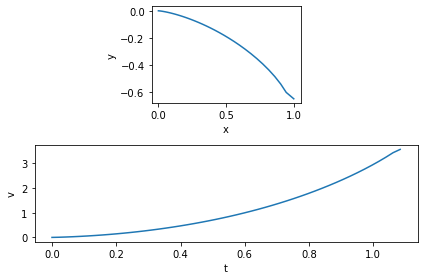

In [31]:
def solve_with_ad(dx, dy, backend):
    model = Brachistochrone()
    sim_config = ScaledMeshOCP.get_sim_config(
        boundary_conditions=(
            BoundaryConditionConfig(0, "states", "x", 0.0),
            BoundaryConditionConfig(0, "states", "y", 0.0),
            BoundaryConditionConfig(0, "states", "v", 0.0),
            BoundaryConditionConfig(-1, "states", "x", dx),
            BoundaryConditionConfig(-1, "states", "y", dy),
        ),
        bounds=(
            BoundConfig("global", "mesh_scale", (0.01, 10.0)),
            BoundConfig("inputs", "theta", (-np.pi / 2, np.pi / 2)),
        ),
        num_intervals=49,
        hessian_approximation="exact",
        backend=backend,
        # transcription="LGR",
        # is_condensed=False,
    )
    ocp = CustomSimulation(model=model, sim_config=sim_config)
    # Very casual initial guess -- just all zeros.
    x0 = np.zeros(ocp.num_dec)
    solution, info = ocp.solve(
        x0,
        max_iter=200,
        print_level=1,
        print_timing_statistics="no",
        derivative_test="none",
    )
    vars = ocp.dec_var_operator.unflatten_var(solution)
    op = ocp.dec_var_operator
    final_t = ocp.objective(solution)
    y = vars.states[:, op.get_var_index_in_group("states", "y")]
    x = vars.states[:, op.get_var_index_in_group("states", "x")]
    v = vars.states[:, op.get_var_index_in_group("states", "v")]
    theta = vars.states[:, op.get_var_index_in_group("inputs", "theta")]
    t = ocp.get_mesh_from_scale(vars.mesh_scale)
    min_y = np.min(y)
    logger.info(f"minimum height {min_y:.3f}")
    logger.info(f"final time {final_t:.3f}")
    return t, x, y, v, theta

logger = logging.getLogger()
logger.setLevel(logging.INFO)
t, x, y, v, theta = solve_with_ad(1.0, -0.65, backend="jax")

# Visualize the result
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.plot(x, y)
ax1.set_aspect('equal', adjustable='box')

ax2 = fig.add_subplot(212)
ax2.set_xlabel('t')
ax2.set_ylabel('v')
ax2.plot(t, v)

fig.tight_layout()